# Udacity Self Driving Car Nanodegree
## Advanced Lane Finding Project
### Brian Fischer


## Table of Contents
[Introduction](#introduction)
1. [Camera Calibration](#calibration)
2. [Perspective Transform](#perspective)
3. [Thresholded Binary Image](#binary)
4. [Detect Lane Lines](#detection)
5. [Determine Lane Curvature](#curvature)
6. [Reproject Lane Boundaries](#boundaries)
Warp the detected lane boundaries back onto the original image
7. [Overlay Calculations](#calculations)
Output a visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position!

## Introduction <a name="introduction"></a>

The goal of this project is to develop a software pipeline which identifies lane boundaries from a front-facing camera on a vehicle.  Images are provided by Udacity for calibration and driving scenarios.

For this project, I will use OpenCV to read and process images.  It is important to note that OpenCV reads images in the BGR format where matplotlib uses RGB.

## Imports <a name="imports"></a>
All of the required project imports are listed at the top of this notebook

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Step 1 - Camera Calibration <a name="calibration"></a>
In this section, we gather and inspect calibration data to correct for lens distortion and misalignment with respect to the imager.
Lesssons 13.3 through 13.11 provide example code and information on this topic.

We start by inspecting the calibration images to determine:
1. The image properties (dimensions, type)
2. The number of "corners" (intersections of 4 squares)
3. The quality of the calibration image set (if there are any issues)

20 calibration images found
Calibration Image Shape: (720, 1280, 3)
Calibration Image Aspect Ratio:  1.778


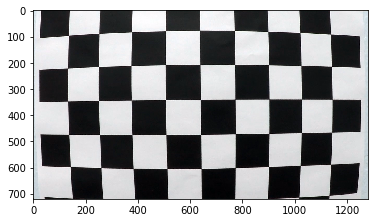

All calibration images:


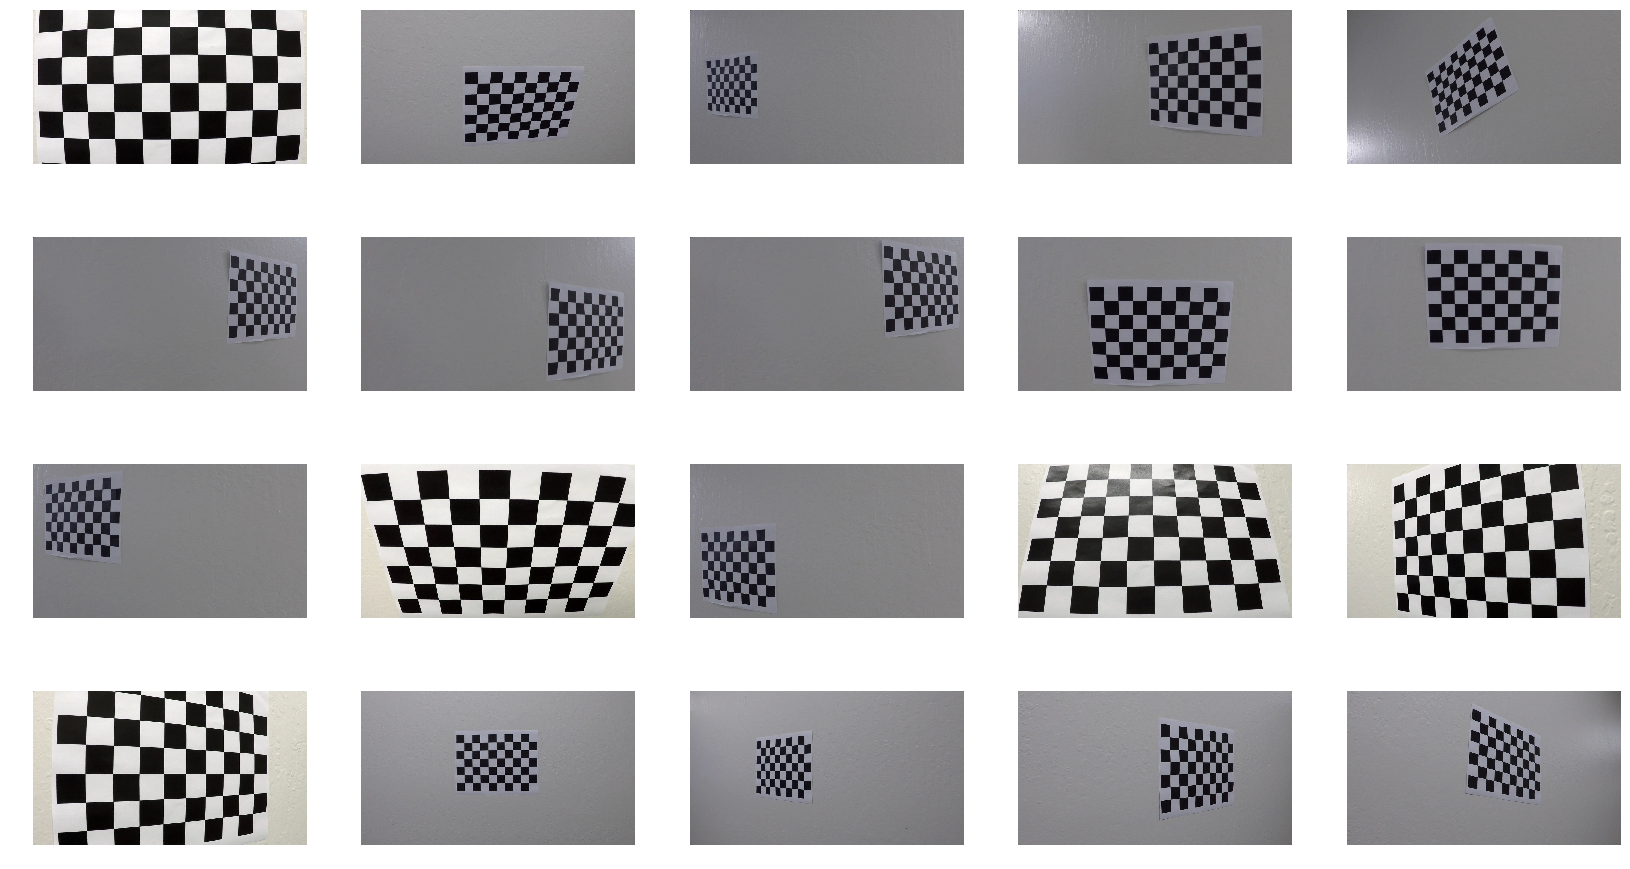

In [4]:
# List all calibration image names
images = glob.glob('camera_cal/calibration*.jpg')
print(len(images), 'calibration images found')

img = cv2.imread(images[0])
print("Calibration Image Shape:", img.shape)
plt.imshow(img)
aspect_ratio = img.shape[1]/img.shape[0]
print("Calibration Image Aspect Ratio: ", format(aspect_ratio, ".3f"))
plt.show()
print("All calibration images:")

# Setup the plot
fig, axes = plt.subplots(4,5, figsize=(16*aspect_ratio,16))
axes = axes.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    axes[i].axis("off")
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig.subplots_adjust(wspace=None, hspace=None)
#plt.tight_layout()

The calibration images have a height of 720 pixels and width of 1280 pixels.
It is also observed that some of the calibration images are missing corners.  We will exclude these from the calibration set since it is better to have additional corners than additional images of poor quality.

The next step below is to iterate through the calibration images of good quality and find the corners.
&nbsp;

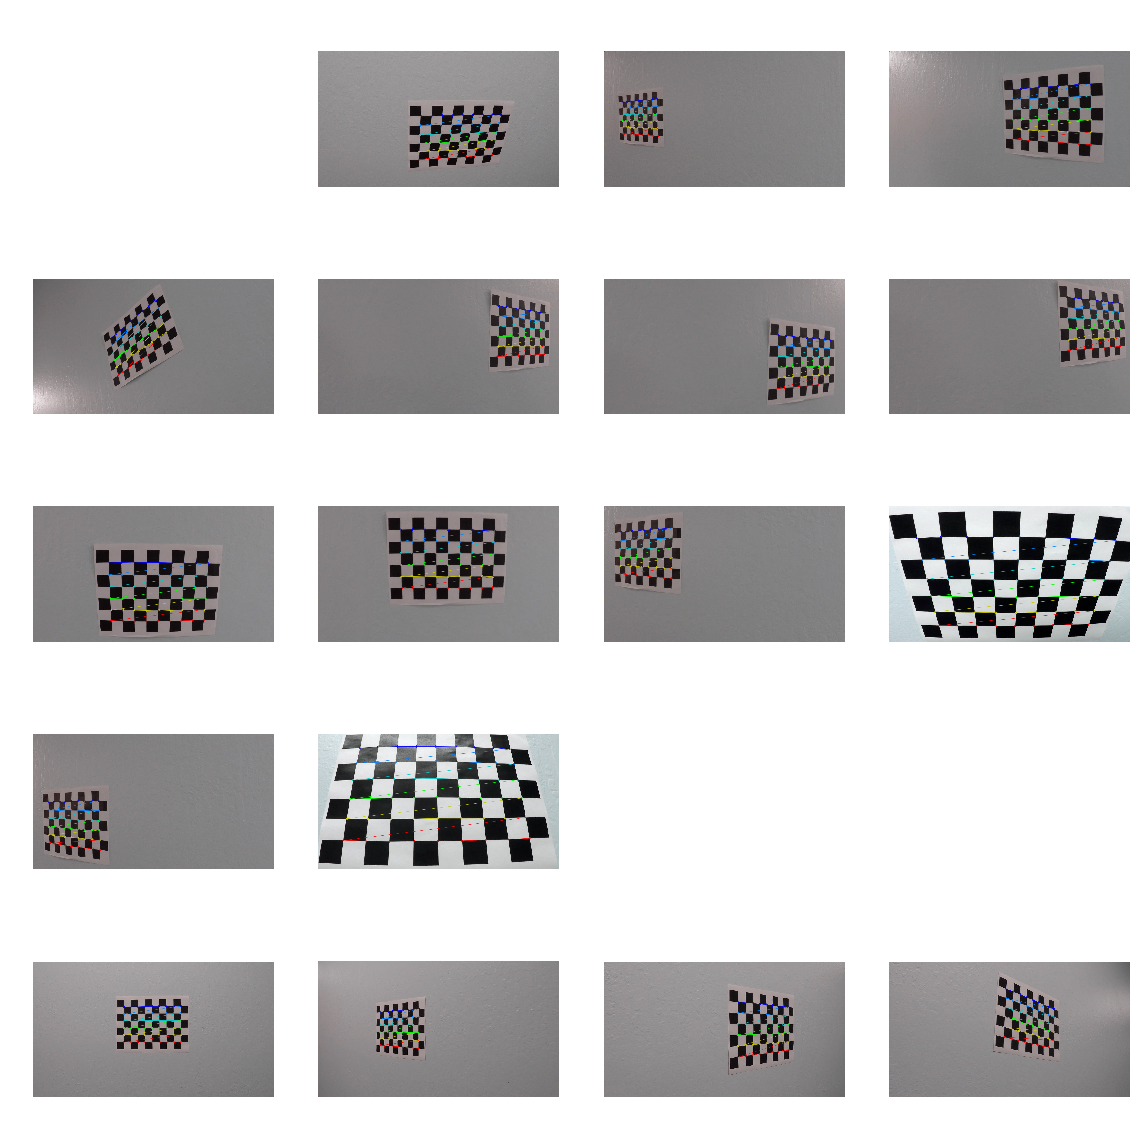

In [18]:
# Define the number of corners
nx = 9   # horizontal corners
ny = 6   # vertical corners

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# List all calibration image names
images = glob.glob('camera_cal/calibration*.jpg')

img = cv2.imread(images[0])
aspect_ratio = img.shape[1]/img.shape[0]

# Setup the plot
#fig, axes = plt.subplots(5,4, figsize=(20*aspect_ratio,20))
fig, axes = plt.subplots(5,4,figsize=(16,16))
axes = axes.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    axes[i].axis("off")
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)      

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        axes[i].imshow(img)
        
plt.tight_layout()

The blank items above indicate the calibration images that were not of sufficient quality (corners were missing).

We now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

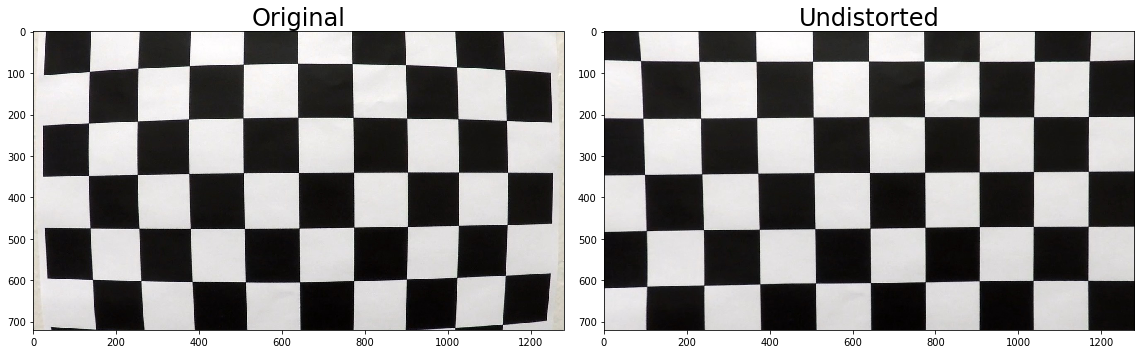

In [49]:
# Test undistortion on an image - we select the calibration image with the most visible of distortion
img = cv2.imread('camera_cal/calibration1.jpg')

# Do camera calibration given object points and image points for multiple camera calibration images
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Undistort a test image
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/calibration.p", "wb" ) )

fig = plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original', fontsize=24)
plt.subplot(122)
plt.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
plt.title('Undistorted', fontsize=24)
plt.tight_layout()

Upon inspection of the calibration quality, it appears the left portion of the image does not have the best calibration as the line is skewed.  This could be corrected by additional calibration images.  Since we don't have the camera we will accept this for now.

The code below displays original and undistorted test images.

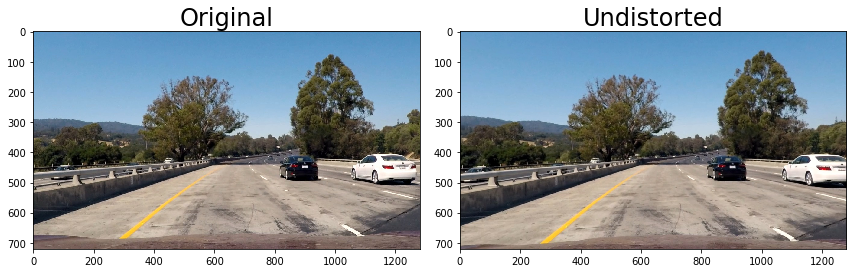

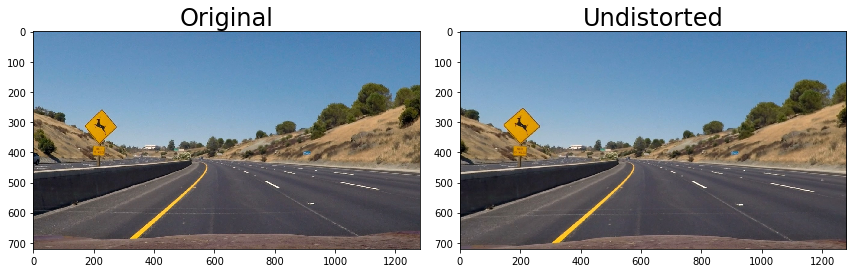

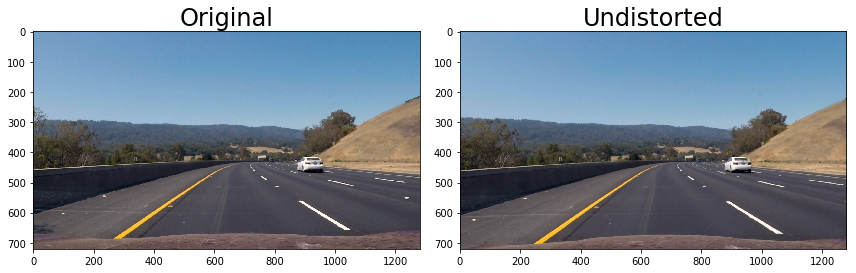

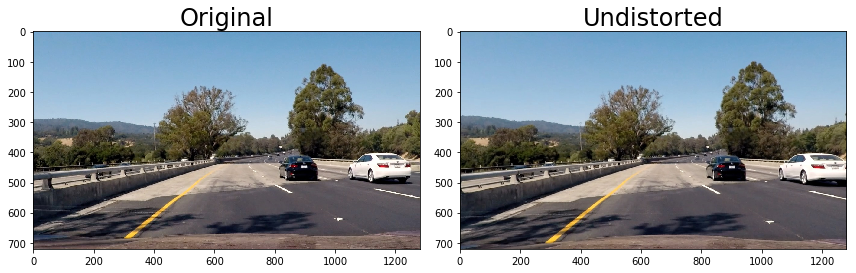

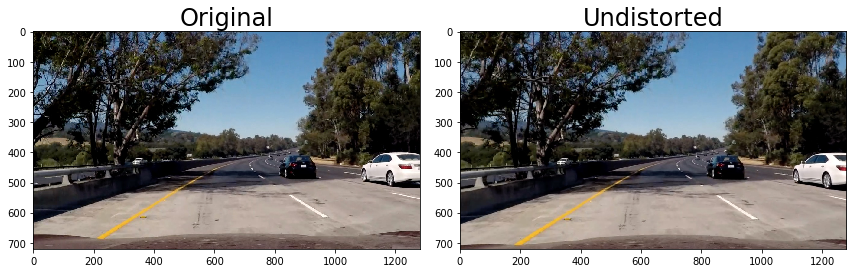

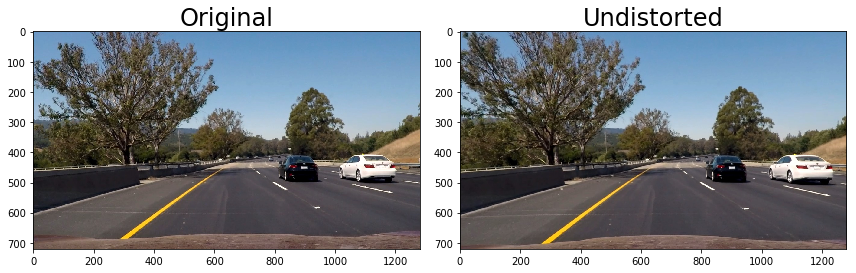

In [54]:
test_images = glob.glob('test_images/test*.jpg')

for i, fname in enumerate(test_images):
    img = cv2.imread(fname)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    fig = plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original', fontsize=24)
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    plt.title('Undistorted', fontsize=24)
    plt.tight_layout()

It is most readily observed the hood of the car is mostly removed in the undisorted images.  In addition, some of the information on the edge of the images is removed in the undistorted image which slightly reduces the field of view.

We then define an abstraction function for undistoration for use with the pipeline:

In [55]:
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

## Step 2 - Perspective Transform<a name="perspective"></a>

I decided to do a perspective transform before attempting to detect the lane lines.  It is easier for me to visualize the best thresholding from a birds eye perspective.

I will use the straight lines example images for the undistortion assuming the road surface is flat.
The test image is read in, then we apply our camera calibration to undistort the image.  The next step is to select the points within the image for the perspective transform to a birds eye view.

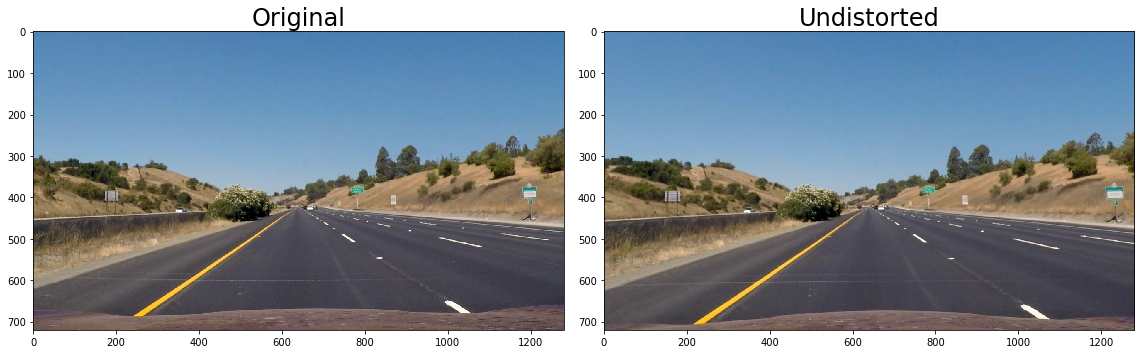

In [64]:
img = cv2.imread('test_images/straight_lines1.jpg')
img_undistort = undistort(img)
cv2.imwrite('output_images/straight_lines1_undistort.jpg', img_undistort)

fig = plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original', fontsize=24)
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_undistort, cv2.COLOR_BGR2RGB))
plt.title('Undistorted', fontsize=24)
plt.tight_layout()

In [65]:
# Define the function for the perspective transform for the pipeline
def birds_eye_view(img):
    img_size = (img.shape[1], img.shape[0])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

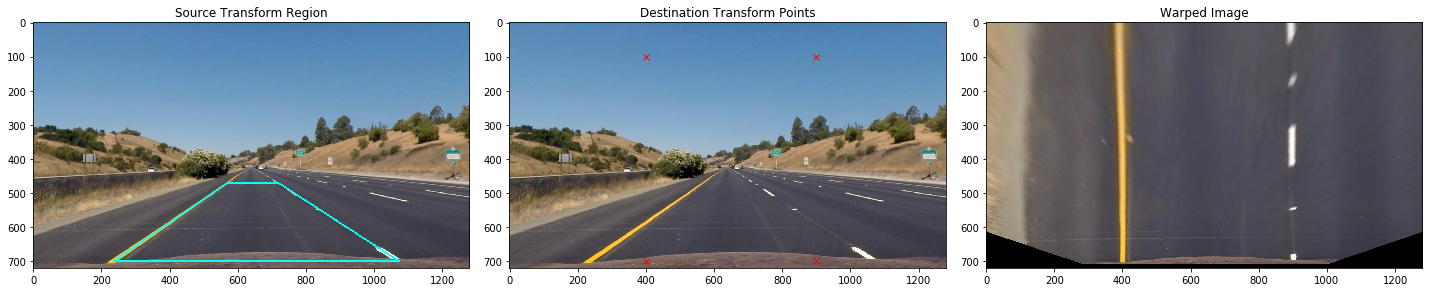

In [68]:
# Manually selecting points for transform
# Order is starting at top right going clockwise around the trapezoid
img = cv2.imread('test_images/straight_lines1.jpg')
img_undistort = undistort(img)
tf_img = img_undistort.copy()

src = np.float32([(718, 470),
                  (1072,700),
                  (235, 700),
                  (570, 470)])

dst = np.float32([(900,100),
                  (900,700),
                  (400,700),
                  (400,100)])


# Plot our source transform using OpenCV polylines function
# https://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html
pts = src.astype(np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(tf_img,[pts],True,(255,255,0), thickness=3)

# Obtain one birds eye view image
warped, M, Minv = birds_eye_view(img_undistort)

# Plot the results for review
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title('Source Transform Region')
plt.imshow(cv2.cvtColor(tf_img, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,2)
plt.title('Destination Transform Points')
plt.imshow(cv2.cvtColor(img_undistort, cv2.COLOR_BGR2RGB))
for point in dst:
    plt.plot(point[0],point[1],'x',color='red')
plt.subplot(1,3,3)
plt.title('Warped Image')
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.tight_layout()

In [ ]:
test_images = glob.glob('test_images/test*.jpg')
for i, fname in enumerate(test_images):
    img = cv2.imread(fname)
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    warped, M, Minv = birds_eye_view(img_undistort)
    
    fig = plt.figure(figsize=(12,12))
    plt.subplot(2,4,i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

The above images demonstrate the source and destination points for the transform.  The warped image on the right shows an acceptable number of lane markings with parallel lane lines.

## Step 3 - Thresholded Binary Image<a name="binary"></a>

The purpose of this step is to create a binary image that only contains pixels likely to contain lane lines.
We model the order of our filters based upon human intuition.  First, we look at the color of objects within a region of interest.  Next, we look at the shape of those objects.
Since lane lines are yellow and white, we will create inclusive filters for these colors.
Since the lane lines will be near vertical, we can use this information during gradient threshold filters.

Methods for creating this thresholded binary image from the source images are as follows:
* Color Transforms
* Gradient Thresholds

#### Color Transforms Used:
1. Inclusive only filter for yellow and white<br>
Lane lines are yellow or white

2. L channel threshold<br>
Ignore lighting conditions (shadows and bright light)

3. S channel threshold<br>
Separates white and yellow lanes well

#### Grandient Thresholds Reviewed:
1. Directional
2. Magnitude

We first review the images in different color spaces.  From the lessons, we already know the RGB color space has issues with brightness, so we explore the other color spaces available in OpenCV:

In [ ]:
img = cv2.imread('test_images/test5.jpg')

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original')

fig, axs = plt.subplots(4, 3, figsize=(20,16))
axs = axs.ravel()

img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
axs[0].imshow(img_HSV[:,:,0], cmap='gray')
axs[0].set_title('HSV H channel')
axs[1].imshow(img_HSV[:,:,1], cmap='gray')
axs[1].set_title('HSV S channel')
axs[2].imshow(img_HSV[:,:,2], cmap='gray')
axs[2].set_title('HSV V channel')

img_HLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
axs[3].imshow(img_HLS[:,:,0], cmap='gray')
axs[3].set_title('HLS H channel')
axs[4].imshow(img_HLS[:,:,1], cmap='gray')
axs[4].set_title('HLS L channel')
axs[5].imshow(img_HLS[:,:,2], cmap='gray')
axs[5].set_title('HLS S channel')

img_LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
axs[6].imshow(img_LAB[:,:,0], cmap='gray')
axs[6].set_title('LAB L channel')
axs[7].imshow(img_LAB[:,:,1], cmap='gray')
axs[7].set_title('LAB A channel')
axs[8].imshow(img_LAB[:,:,2], cmap='gray')
axs[8].set_title('LAB B channel')

img_LUV = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
axs[9].imshow(img_LUV[:,:,0], cmap='gray')
axs[9].set_title('LUV L channel')
axs[10].imshow(img_LUV[:,:,1], cmap='gray')
axs[10].set_title('LUV U channel')
axs[11].imshow(img_LUV[:,:,2], cmap='gray')
axs[11].set_title('LUV V channel')

plt.tight_layout()

Review of the above images indicates

In [ ]:
img = warped.copy()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original')

fig, axs = plt.subplots(4, 3, figsize=(20,16))
axs = axs.ravel()

img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
axs[0].imshow(img_HSV[:,:,0], cmap='gray')
axs[0].set_title('HSV H channel')
axs[1].imshow(img_HSV[:,:,1], cmap='gray')
axs[1].set_title('HSV S channel')
axs[2].imshow(img_HSV[:,:,2], cmap='gray')
axs[2].set_title('HSV V channel')

img_HLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
axs[3].imshow(img_HLS[:,:,0], cmap='gray')
axs[3].set_title('HLS H channel')
axs[4].imshow(img_HLS[:,:,1], cmap='gray')
axs[4].set_title('HLS L channel')
axs[5].imshow(img_HLS[:,:,2], cmap='gray')
axs[5].set_title('HLS S channel')

img_LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
axs[6].imshow(img_LAB[:,:,0], cmap='gray')
axs[6].set_title('LAB L channel')
axs[7].imshow(img_LAB[:,:,1], cmap='gray')
axs[7].set_title('LAB A channel')
axs[8].imshow(img_LAB[:,:,2], cmap='gray')
axs[8].set_title('LAB B channel')

img_LUV = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
axs[9].imshow(img_LUV[:,:,0], cmap='gray')
axs[9].set_title('LUV L channel')
axs[10].imshow(img_LUV[:,:,1], cmap='gray')
axs[10].set_title('LUV U channel')
axs[11].imshow(img_LUV[:,:,2], cmap='gray')
axs[11].set_title('LUV V channel')

plt.tight_layout()

### HLS L Channel Filter
Filter only the white lane lines

In [ ]:
# Define a function that thresholds the L-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_lthresh(img, thresh=(210, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output
print('...')

In [ ]:
img = warped.copy()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original')

def update(min_thresh, max_thresh):
    exampleImg_LThresh = hls_lthresh(img, (min_thresh, max_thresh))
    # Visualize hls l-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(img)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_LThresh, cmap='gray')
    ax2.set_title('HLS L-Channel', fontsize=30)
    print(min_thresh)

interact(update,
         min_thresh=(0,255), 
         max_thresh=(0,255))

print('...')

In [ ]:
test_images = glob.glob('test_images/test*.jpg')

for i, fname in enumerate(test_images):
    img = cv2.imread(fname)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    bev_undist, M, Minv = birds_eye_view(undist)
    img_hls = hls_lthresh(bev_undist, thresh=(210, 255))
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(cv2.cvtColor(bev_undist, cv2.COLOR_BGR2RGB))
    ax2.set_title('Birds Eye', fontsize=30)
    ax3.imshow(img_hls, cmap='gray')
    ax3.set_title('Filtered HLS L channel', fontsize=30)

### LAB B Channel Filter
Filter only the yellow lines

In [ ]:
# Define a function that thresholds the B-channel of LAB
# Use exclusive lower bound (>) and inclusive upper (<=), OR the results of the thresholds (B channel should capture
# yellows)
def lab_bthresh(img, thresh=(180,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [ ]:
def update(min_b_thresh, max_b_thresh):
    exampleImg_LBThresh = lab_bthresh(warped, (min_b_thresh, max_b_thresh))
    # Visualize LAB B threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(warped)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_LBThresh, cmap='gray')
    ax2.set_title('LAB B-channel', fontsize=30)

interact(update,
         min_b_thresh=(0,255),
         max_b_thresh=(0,255))

In [ ]:
test_images = glob.glob('test_images/test*.jpg')

for i, fname in enumerate(test_images):
    img = cv2.imread(fname)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    bev_undist, M, Minv = birds_eye_view(undist)
    img_lab = lab_bthresh(bev_undist, thresh=(180,255))
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(cv2.cvtColor(bev_undist, cv2.COLOR_BGR2RGB))
    ax2.set_title('Birds Eye', fontsize=30)
    ax3.imshow(img_lab, cmap='gray')
    ax3.set_title('Filtered LAB B channel', fontsize=30)

In [ ]:
# Define the complete image processing pipeline, reads raw image and returns binary image with lane lines identified
# (hopefully)
def pipeline(img):
    # Undistort
    img_undistort = undistort(img)
    
    # Perspective Transform
    img_unwarp, M, Minv = birds_eye_view(img_undistort)

    # Sobel Absolute (using default parameters)
    #img_sobelAbs = abs_sobel_thresh(img_unwarp)

    # Sobel Magnitude (using default parameters)
    #img_sobelMag = mag_thresh(img_unwarp)
    
    # Sobel Direction (using default parameters)
    #img_sobelDir = dir_thresh(img_unwarp)
    
    # HLS S-channel Threshold (using default parameters)
    #img_SThresh = hls_sthresh(img_unwarp)

    # HLS L-channel Threshold (using default parameters)
    img_LThresh = hls_lthresh(img_unwarp)

    # Lab B-channel Threshold (using default parameters)
    img_BThresh = lab_bthresh(img_unwarp)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1
    return combined, Minv

In [ ]:
test_images = glob.glob('test_images/test*.jpg')

fig, axs = plt.subplots(len(test_images),2, figsize=(20, 10))
axs = axs.ravel()

for i, fname in enumerate(test_images):
    # Read image
    img = cv2.imread(fname)  
    axs[i*2].imshow((cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
    
    # Undistort
    img_undistort = undistort(img)
    
    # Perspective Transform
    img_unwarp, M, Minv = birds_eye_view(img_undistort)
    
    # HLS L-channel Threshold (using default parameters)
    img_LThresh = hls_lthresh(img_unwarp)
    
    # Lab B-channel Threshold (using default parameters)
    img_BThresh = lab_bthresh(img_unwarp)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1
    
    axs[i*2+1].imshow(combined, cmap='gray')
    plt.tight_layout()

### Sobel Absolute Directional Gradient Threshold

We start out with some inspection of gradient thresholds.  Since the gradient in the x direction emphasized edges closer to vertical, we expect this to be more useful in filtering the lane lines.

In [ ]:
# Sobel X gradient
gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

# Calculate the derivative in the x direction (the 1, 0 at the end denotes x direction):
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)

# Calculate the derivative in the y direction (the 0, 1 at the end denotes y direction):
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

# Calculate the absolute value of the x derivative:
abs_sobelx = np.absolute(sobelx)

# Convert the absolute value image to 8-bit:
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
plt.imshow(sxbinary, cmap='gray')

In [ ]:
# Absolute value of Sobel directional gradient
def abs_dir_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # <-- We are using OpenCV to read images!
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [ ]:
# Read in an image and grayscale it
image = cv2.imread('test_images/straight_lines1.jpg')
    
# Run the absolute x
grad_x_binary = abs_dir_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)

# Run the absolute =y
grad_y_binary = abs_dir_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=100)


# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')
ax2.imshow(grad_x_binary, cmap='gray')
ax2.set_title('Sobel x Thresholded Gradient')
ax3.imshow(grad_y_binary, cmap='gray')
ax3.set_title('Sobel y Thresholded Gradient')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

The x threshold appears to be a good representation of the lane lines.
It is confirmed in the above image the y threshold does not add value to our goal of detecting the lane lines.

It was observed setting the minimum threshold above 15 will remove the yellow line in the test image below.

In [ ]:
birds_eye_x_grad = abs_dir_sobel_thresh(warped, 'x', thresh_min=15, thresh_max=100)
plt.imshow(birds_eye_x_grad, cmap='gray')

### Sliding Window Polyfit

Testing using a reference pipeline for lane fit...

ToDo: Code for this comes from 33. Finding Lanes

In [ ]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data
print('...')

### ToDo: This code comes from 33. Finding the Lines

In [ ]:

# visualize the result on example image
exampleImg = cv2.imread('./test_images/test2.jpg')
#exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_bin, Minv = pipeline(exampleImg)
plt.imshow(exampleImg_bin)
    
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)

h = exampleImg.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
#print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

rectangles = visualization_data[0]
histogram = visualization_data[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = exampleImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [ ]:
# Print histogram from sliding window polyfit for example image
plt.plot(histogram)
plt.xlim(0, 1280)
print('...')

### Polyfit Using Fit from Previous Frame
The test images test6, test4, and test5 appear, respectively, to be chronologically ordered frames from a single video capture

In [ ]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds
print('...')

In [ ]:
# visualize the result on example image
exampleImg2 = cv2.imread('./test_images/test5.jpg')
#exampleImg2 = cv2.cvtColor(exampleImg2, cv2.COLOR_BGR2RGB)
exampleImg2_bin, Minv = pipeline(exampleImg2)   
margin = 80

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(exampleImg2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg2_bin.shape[0]-1, exampleImg2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
print('...')

### Radius of Curvature and Distance from Lane Center Calculation

In [ ]:

# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist
print('...')

In [ ]:
# Calculate curvature radius and distance from center for example image
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exampleImg_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

### Draw the Detected Lane Back onto the Original Image

In [ ]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result
print('...')

In [ ]:
# Draw detected lane onto example image
exampleImg_out1 = draw_lane(exampleImg, exampleImg_bin, left_fit, right_fit, Minv)
plt.imshow(cv2.cvtColor(exampleImg_out1, cv2.COLOR_BGR2RGB))
print('...')

### Draw Curvature Radius and Distance from Center Data onto the Original Image

In [ ]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img
print('...')

In [ ]:
# Write data onto example image
exampleImg_out2 = draw_data(exampleImg_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(cv2.cvtColor(exampleImg_out2, cv2.COLOR_BGR2RGB))
print('...')

### Define a Line Class for Storing Data

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


            

print('...')

### Define Complete Image Processing Pipeline

In [ ]:
def process_image(img):
    new_img = np.copy(img)
    new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR)
    img_bin, Minv = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    diagnostic_output = True
    if diagnostic_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # binary overhead view (top right)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        resized_img_bin = cv2.resize(img_bin,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        
        # overhead with all fits added (bottom right)
        img_bin_fit = np.copy(img_bin)
        for i, fit in enumerate(l_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, l_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, r_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        
        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if l_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(l_fit[0]) + \
                                    ' {:0.6f}'.format(l_fit[1]) + \
                                    ' {:0.6f}'.format(l_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if r_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(r_fit[0]) + \
                                    ' {:0.6f}'.format(r_fit[1]) + \
                                    ' {:0.6f}'.format(r_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(l_line.best_fit[0]) + \
                                ' {:0.6f}'.format(l_line.best_fit[1]) + \
                                ' {:0.6f}'.format(l_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(r_line.best_fit[0]) + \
                                ' {:0.6f}'.format(r_line.best_fit[1]) + \
                                ' {:0.6f}'.format(r_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(l_line.diffs[0]) + \
                             ' {:0.6f}'.format(l_line.diffs[1]) + \
                             ' {:0.6f}'.format(l_line.diffs[2])
        if l_line.diffs[0] > 0.001 or \
           l_line.diffs[1] > 1.0 or \
           l_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(r_line.diffs[0]) + \
                             ' {:0.6f}'.format(r_line.diffs[1]) + \
                             ' {:0.6f}'.format(r_line.diffs[2])
        if r_line.diffs[0] > 0.001 or \
           r_line.diffs[1] > 1.0 or \
           r_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(l_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(r_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
    return cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)
print('...')

Method for plotting a fit on a binary image - diagnostic purposes

In [ ]:
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img
print('...')

### Generate Project Video

In [ ]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)